In [1]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
import cmath
import wave, sys
import IPython.display as ipd
from scipy.signal import filtfilt
from scipy.signal import butter
from scipy.signal import find_peaks

# Question 1

In [41]:
signal, sr = librosa.load(r"C:\Users\Venkatesh Yeturi\OneDrive\Desktop\Class pdfs\Biomedical Signal Processing\Assignments\Assignment4\inputSpeech1.wav")

In [42]:
signal

array([ 0.0008155 , -0.00114762,  0.00157987, ..., -0.03863942,
       -0.04291013,  0.        ], dtype=float32)

In [43]:
len(signal)  # The signal given

105859

In [44]:
sr # number of samples per second i.e sampling rate of given signal

22050

In [45]:
signal /= np.abs(signal).max()      # Normalising the signal 

In [46]:
fs = 32000        # Sampling Frequency according to question

In [47]:
N = len(signal) # length of signal
N

105859

In [48]:
duration = N/fs
print(duration)

3.30809375


In [49]:
t = np.linspace(0,duration,N)
t[:5]

array([0.00000000e+00, 3.12502952e-05, 6.25005904e-05, 9.37508856e-05,
       1.25001181e-04])

In [51]:
display(ipd.Audio(signal, rate = fs ))

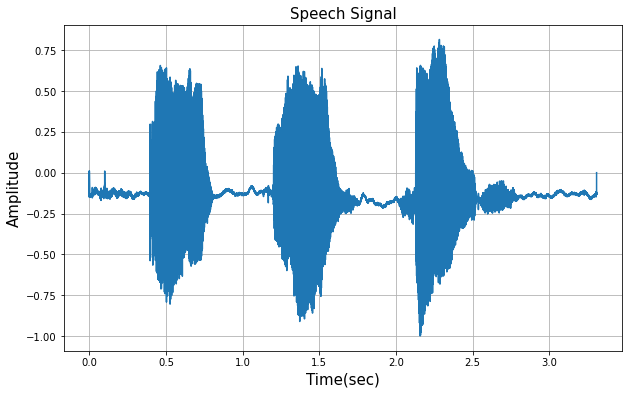

In [52]:
plt.figure(figsize=(10,6))
plt.plot(t,signal)
plt.xlabel('Time(sec)',size=15)
plt.ylabel('Amplitude',size=15)
plt.title('Speech Signal',size=15)
plt.grid()

In [53]:
def Bandpass_filter(signal):
    
    order = 5         # Order of the filter
    fs = 32000        # Sampling frequency
    nyq_rate = 0.5*fs   
    lowcut = 100      # Lower cutoff frequency
    highcut = 4000    # Higher cutoff frequency
    
    low = lowcut/nyq_rate    # normalizing the low freq to feed it to the butter filter
    high = highcut/nyq_rate  # normalizing the high freq to feed it to the butter filter
    
    # butter filter accepts normalized frequencies w.r.t nyquist rate
    b, a = butter(order,[low,high], btype='bandpass')
    y = filtfilt(b,a,signal)

    return y

In [55]:
signal1 = Bandpass_filter(signal)

display(ipd.Audio(signal1, rate = fs ))

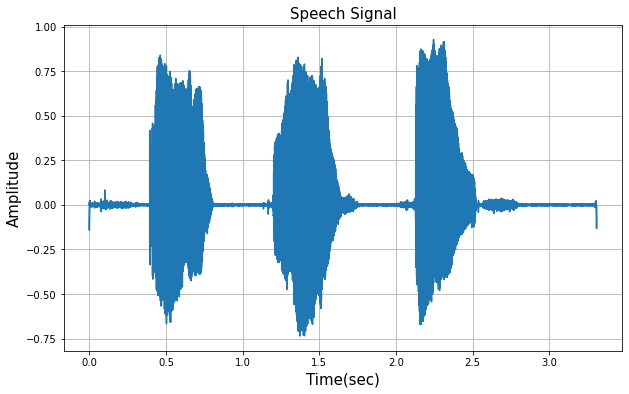

In [15]:
plt.figure(figsize=(10,6))
plt.plot(t,signal1)
plt.xlabel('Time(sec)',size=15)
plt.ylabel('Amplitude',size=15)
plt.title('Speech Signal',size=15)
plt.grid()

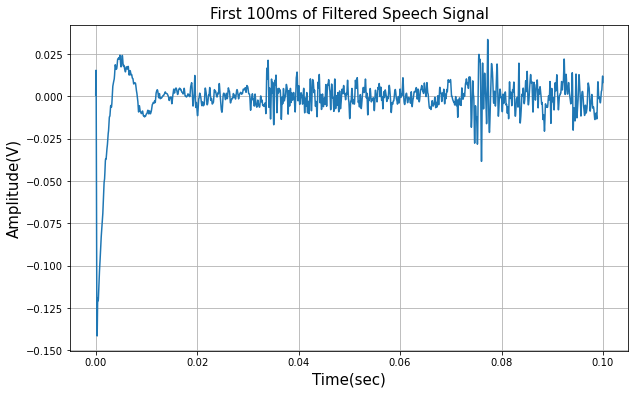

In [56]:
# first 100ms of the filtered signal to observe noise
N1 = int(fs * 0.1)

signal2 = signal1[0:N1]

timePeriod = N1/fs
t1 = np.linspace(0,timePeriod,N1)
plt.figure(figsize=(10,6))
plt.plot(t1,signal2)
plt.xlabel('Time(sec)',size=15)
plt.ylabel('Amplitude(V)',size=15)
plt.title('First 100ms of Filtered Speech Signal',size=15)
plt.grid()


In [17]:
# Finding energy of silence in the signal
n = int(fs*0.01)   # Considering 10ms interval so n is no.of indices in 10ms
E = np.zeros(10)
i=j=k=0
for j in range(10):
    i = 0
    while(i<n):
        E[j] += abs(signal2[i+k])
        i += 1
    k += n
IMN = np.mean(E)
print(f'Avg energy of silence for 10ms window is : {IMN:.2f}')

Avg energy of silence for 10ms window is : 2.25


In [18]:
# computing zero crossing rate

In [19]:
zcr = np.where(np.diff(np.sign(signal2)))[0]
zcr[:5]

array([  3, 104, 262, 379, 395], dtype=int64)

In [20]:
len(zcr)   # all the indices where there is a zero crossing

234

In [57]:
zero_crossing = np.zeros(10)
i=j=0 
while (i<N1):
    zero_crossing[j] = len(np.where(np.diff(np.sign(signal2[i:i+n])))[0])
    j += 1
    i += n           # n is no.of indices in 10ms interval
# so we now got 10 frames and so 10 zerocrossing counts. (10 frames * 10 msec = 100 msec)
ZC_mean = np.mean(zero_crossing)     # Mean of zero crossing rate
print(ZC_mean)
ZC_stddev = np.std(zero_crossing)    # Standard Deviation of zero crossing rate
IF = 25                              # Fixed threshold of ZCR

# Zero Crossing Threshold:
IZCT = np.minimum(IF,ZC_mean+2*ZC_stddev)  # set a threshold based on maximum value as 25 (it shouldnt be more than 25)

23.3


In [22]:
# finding the energy of entire signal

In [23]:
N2 = int(N/(fs*0.01)) # gives no.of 10ms frames-total we have 3.3 sec data i.e 3300 msec data 
print(N2,fs,N)        # so we divide into 10 frames and so 330*10 = 3300
Energy = np.zeros(N2)
i=j=k=0
for j in range(N2):
    i = 0
    while(i<n):
        Energy[j] += abs(signal1[i+k])
        i += 1
    k += n
# Peak Energy
IMX = max(Energy)
I_mean = Energy.mean()

IMX,I_mean

330 32000 105859


(95.73146076813538, 24.949921066196023)

In [24]:
# # finding lower and upper energy threshold 
I1  = 0.03*(IMX-IMN) + IMN
I2 = 4*IMN
ITL = min(I1,I2)
ITU = 5*ITL
ITU

# consider setting the threshold simply the average of whole signal. 
# ITU = I_mean

25.24876447452123

In [25]:
# 1st iteration - finding Beginning point estimate 
## Function to compute begining point
    
def find_begin(m): # computes the beginning point estimate given the starting index m
    n2 = int(N/(fs*0.01)) # no.of 10ms frames
    N1=0
    j=0
    while(j<=n2):
        if Energy[m] >= ITL:  # already we have energies of each 10ms frame
            i = m
            N1 = get_index(i)
        else:
            m += 1
        j += 1
    return N1
    
def get_index(i):  # computing beg point estimate given frame index i
    while(True):
        if Energy[i] >= ITU:
            N1 = i*n
            break
        else:
            i +=1
    return N1

def get_beginning_point(m):
    N1 = find_begin(m)
    return N1

In [26]:
N1 = np.zeros(3)
x_begin = [1,93,187]    # Initializing Begining Points

for i in range(3):

    N1[i] = get_beginning_point(x_begin[i])
    
print(f'\nEstimate of the Begining Points:\n {N1}')


Estimate of the Begining Points:
 [12800. 38400. 68160.]


In [27]:
# 1st iteration - ending point estimate
## Function to compute ending point 
    
def find_end(m):
    n2 = int(N/(fs*0.01))
    N2=0
    j=0
    while(j<=n2):
        if Energy[m] >= ITL:
            i = m
            N2 = get_end_index(i)
        else:
            m -= 1
        j += 1
    return N2
    
def get_end_index(i):
    while(True):
        if Energy[i] >= ITU:
            N2 = i*n
            break
        else:
            i -=1
    return N2

def get_ending_point(m):

    N2 = find_end(m)
    return N2
    

In [28]:
N2 = np.zeros(3)
x_end = [312,187,93]    # Initializing Ending Points

for i in range(3):

    N2[i] = get_ending_point(x_end[i])
    
print(f'\nEstimate of the Begining Points:\n {N2}')
N2 = np.sort(N2)


Estimate of the Begining Points:
 [80000. 51200. 24320.]


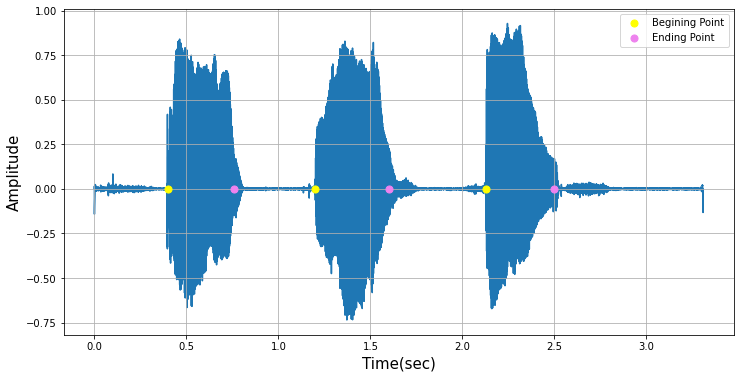

In [29]:
y = [0,0,0]
plt.figure(figsize=(12,6))
plt.plot(t,signal1,zorder=1)
plt.xlabel('Time(sec)',size=15)
plt.ylabel('Amplitude',size=15)

plt.scatter(N1/fs,y,color='yellow',marker='o',s=50,zorder=2,label='Begining Point')
plt.scatter(N2/fs,y,color='violet',marker='o',s=50,zorder=2,label='Ending Point')

plt.legend()
plt.grid()
plt.show()

In [30]:
#segment the signal 
signal_segment1 = signal1[int(N1[0]):int(N2[0])]
signal_segment2 = signal1[int(N1[1]):int(N2[1])]
signal_segment3 = signal1[int(N1[2]):int(N2[2])]

print('\nPlaying Speech Segment 1...')
display(ipd.Audio(signal_segment1, rate = sr ))

print('\nPlaying Speech Segment 2...')
display(ipd.Audio(signal_segment2, rate = sr ))

print('\nPlaying Speech Segment 3...')
display(ipd.Audio(signal_segment3, rate = sr ))



Playing Speech Segment 1...



Playing Speech Segment 2...



Playing Speech Segment 3...


#  Question 2

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Tue Jan 13 11:22:04 2015', '__version__': '1.0', '__globals__': [], 'original': array([[39.60475775, 40.07076881, 40.5922544 , ..., 54.22427311,
        58.8477386 , 62.91896577]])}
10000


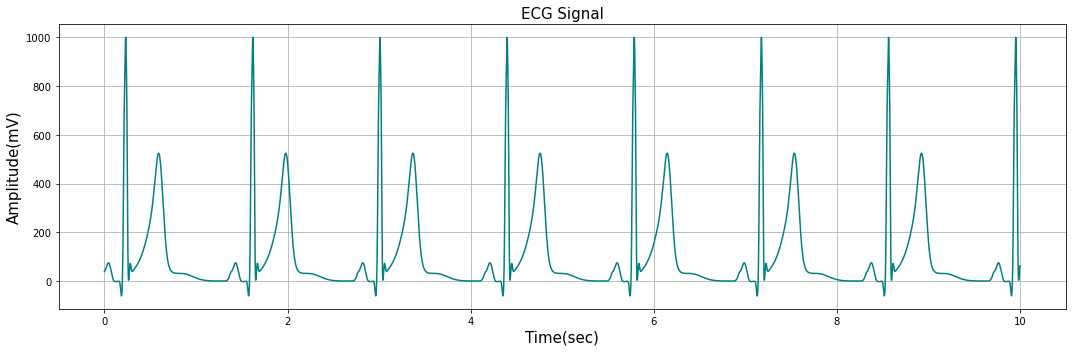

In [58]:
# Reading the given ECG signal
data = loadmat(r"C:\Users\Venkatesh Yeturi\OneDrive\Desktop\Class pdfs\Biomedical Signal Processing\Assignments\Assignment4\original_ECG.mat")
print(data)

Fs = 1000   # Sampling Frequency 
x1 = data['original']
X1 = x1[0]
N = len(X1)
print(N)                       # we have 10000 samples from the input data
t = np.linspace(0,N/Fs,N)

plt.figure(figsize=(15,5))
plt.plot(t,X1, color='teal')
plt.xlabel('Time(sec)',size='15')
plt.ylabel('Amplitude(mV)',size='15')
plt.title('ECG Signal',size='15')
plt.grid(True)
plt.tight_layout()
plt.show()

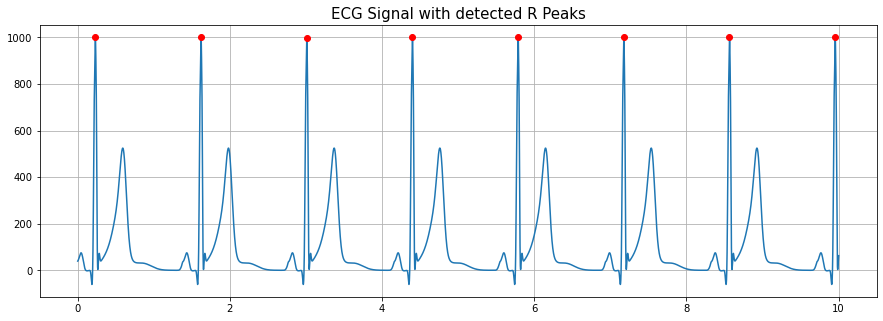

In [59]:
#finding R wave peaks 
# Peak height > 800 and distance between two peaks > 150 samples
peaks1, _ = find_peaks(X1, height= 800)

plt.figure(figsize=(15,5))
plt.plot(t,X1)
plt.plot(peaks1/Fs, X1[peaks1],'o',markersize='6',color='red')
plt.title('ECG Signal with detected R Peaks',size='15')
plt.grid(True)
plt.show()

In [60]:
# Computing diagnostic features of ECG signal before filtering - R amplitude, R-R interval
# Diagnostic features of Original ECG signal
n1 = len(peaks1)
RR_amp = np.round_(X1[peaks1][0:n1-1],2)
RR_int = np.diff(peaks1)                 # interval in no.of indices
RR_int = np.round(RR_int/Fs,2)           # for each sec, we have 360 samples i.e 360 indices. 
                                         # so, n no.of indices correspond to n*(1/360) i.e n/Fs seconds.

print('\nR_wave amplitude (in mV):\n',RR_amp)   # in mV
print('\nRR-interval\n',RR_int)                 # in 

# Diagnostic Feature Vector Alpha:
alpha = np.zeros((n1-1,2))

for j in range(n1-1):
    alpha[j][0] = RR_amp[j]
    alpha[j][1] = RR_int[j]
    
print('\nDiagnostic feature Vector of Original ECG, Alpha =\n',alpha)


R_wave amplitude (in mV):
 [999.8  999.59 999.3  999.49 999.73 999.9  999.99]

RR-interval
 [1.39 1.39 1.39 1.39 1.39 1.39 1.39]

Diagnostic feature Vector of Original ECG, Alpha =
 [[999.8    1.39]
 [999.59   1.39]
 [999.3    1.39]
 [999.49   1.39]
 [999.73   1.39]
 [999.9    1.39]
 [999.99   1.39]]


In [61]:
# Apply filtering to remove high frequency noise
# Defining a function for bandstop filter to filter the ECG signal
def Bandpass_filter(signal):
    
    order = 5       # Order of the filter
    fs = 1000        # Sampling frequency
    nyq = 0.5*fs   
    lowcut = 1      # Lower cutoff frequency
    highcut = 45    # Higher cutoff frequency
    
    low = lowcut/nyq
    high = highcut/nyq
    
    b, a = butter(order,[low,high], btype='bandpass')
    y = filtfilt(b,a,signal)

    return y

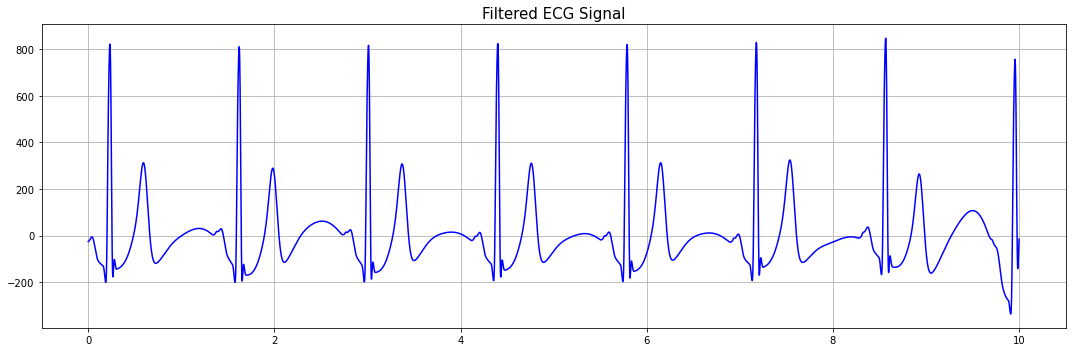

In [62]:
X1_filtered = Bandpass_filter(X1)

plt.figure(figsize=(15,5))

plt.plot(t,X1_filtered, color='blue')
plt.title('Filtered ECG Signal',size=15)
plt.grid(True)

plt.tight_layout()
plt.show()

In [63]:
# Computing features of ECGsignal after filtering
# Diagnostic features of Filtered ECG signal
peaks2, _ = find_peaks(X1_filtered, height= 600)

n2 = len(peaks2)
RR_amp = np.round_(X1_filtered[peaks2][0:n2-1],2)
RR_int = np.round(np.diff(peaks2)/Fs,2)

# Diagnostic Feature Vector Beta:
beta = np.zeros((n2-1,2))

for j in range(n2-1):
    beta[j][0] = RR_amp[j]
    beta[j][1] = RR_int[j]
    
print('\nDiagnostic feature Vector of Filtered ECG, Beta =\n',beta)


Diagnostic feature Vector of Filtered ECG, Beta =
 [[820.98   1.39]
 [809.91   1.39]
 [815.71   1.39]
 [823.39   1.39]
 [819.19   1.39]
 [828.35   1.39]
 [846.68   1.39]]


In [37]:
# Diagonal Weight Matrix:
D =[[0.75, 0],[0, 0.25]]

A = alpha - beta
A_tr =  np.transpose(alpha-beta)
CCD = np.dot(np.dot(A,D),A_tr)

print('\nClinical Component Distortion Measure, CCD=\n\n',np.round_(CCD,2))


Clinical Component Distortion Measure, CCD=

 [[23982.44 25438.93 24622.17 23617.65 24213.12 23007.43 20561.17]
 [25438.93 26983.88 26117.51 25051.99 25683.62 24404.7  21809.88]
 [24622.17 26117.51 25278.97 24247.65 24859.   23621.15 21109.64]
 [23617.65 25051.99 24247.65 23258.41 23844.82 22657.47 20248.42]
 [24213.12 25683.62 24859.   23844.82 24446.02 23228.73 20758.94]
 [23007.43 24404.7  23621.15 22657.47 23228.73 22072.05 19725.25]
 [20561.17 21809.88 21109.64 20248.42 20758.94 19725.25 17627.97]]
